### **Imperative programming**

-> So far, we focused on Imperative programming. which makes use of statements such as `print`, `+ `and `if` to change a program' state

In [1]:
def add(a, b):
    return a+b

def fancy_func(a, b, c, d):
    e= add(a, b)
    f= add(c, d)
    g= add(e, f)
    return g

print(fancy_func(3,6,9,13))

31


-> Python - `Interpreted` language, the above funct performs the op making up the functions body `in sequence`. <br>
-> 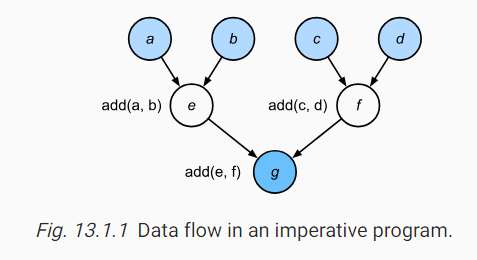 <br>
-> Imperative programming is convinient, it may be inefficient. <br>
-> `add` func is repeatedly called. Python will execute the 3 func invidually. <br>
-> If these are executed on GPU, the overhead arising from the python interpreter can become overwhelming.<br>
-> the variable e, f needs to be saved untill the func have been executed.

### **Symbolic Programming**

-> Consider symbolic programming, where computation is usually performed `only once` the process has been `fully defined`. <br>
-> Usually involves the following steps.<br>
 1. Define the operations to be executed.<br>
 2. Compile the op into an executable program. <br>
 3. Provide the req i/p's and call the compiled progrom for execution
 

In [4]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)


# compile(source, filename, mode)
# SOURCE (a normal string, a byte string, an AST object) ,
# FILENAME (file from which code is to be read), 
# MODE - exec(can take a code block with statements, class and functions)/ eval(accepts single expression)/ single(has a single interactive statement)
y = compile(prog, '', 'exec') 

#exec dynamic execution of python programs which can either be string or object code
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
----------
10


-> Symbolic Programming is more efficient and easier to port. Makes it easier to optimize the code during compilation, while also having the ability to port the programm <br>
   into a format independent of python. <br>
-> This allows the program to be run in a non-python environment, thus avoiding any potential performance issues related to the python interpreter

### **Hybrid Programming**

1. Most DL frameworks choose between imperative or a symbolic approach. 
2. for e.g. **Theano, TensorFlow, Keras, CNTK formulate models symbolically**. **Pytorch, Chainer are an imperative approach.**


### **Hybridizing the Sequential Class**

1. Easiest way to get a feel for how hybridization works is to consider deep n/w with multiple layers.
2. Conventionally the python interpreter will need to execute the code for all layers to generate an instruction that can then be forwarded to CPU or a GPU.
3. For a single computing device this does not cause any major issues.
4. On the other hand, if we use an advanced 8-GPU server instance the python will struggle to keep all the GPUs busy. 
5. the single-threaded python interpreter becomes the bottle neck here. <br>
*replacing Sequential with HybridSequencial. we begin by defining a simple MLP*

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

def get_net():
    net=nn.Sequential(nn.Linear(512, 256), nn.ReLU(),
                      nn.Linear(256, 128), nn.ReLU(),
                      nn.Linear(128, 2))
    return net 

x = torch.rand(size=(1, 512))
net= get_net()
net(x)

tensor([[0.0817, 0.0255]], grad_fn=<AddmmBackward0>)

Converting the model using `torch.jit.script` function, we are able to compile and optimize the computation in the MLP. The models computation results remain unchanged <br>
*jit -> just-in-time*

In [8]:
net = torch.jit.script(net)
net(x)

tensor([[0.0817, 0.0255]], grad_fn=<AddmmBackward0>)

Network is Optimized (Benchmark below)

### **Acceleration by Hybridization**

 To demo the perf improvment gained by compilation we compare the time needed to evalute net(x) before and after hybridization.

In [9]:
#@save
class Benchmark:

    def __init__(self, description="Done"):
        self.description= description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self
    
    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [10]:
# invoking the network twice, once with and witout torchscript

net= get_net()
with Benchmark('without torchscript'):
    for i in range(1000): net(x)

net= torch.jit.script(net)
with Benchmark('with torchscript'):
    for i in range(1000): net(x)

without torchscript: 0.2110 sec
with torchscript: 0.1140 sec


After nn.Sequential instance is scripted usng the torch.jit.script function, computing performance is improved through the use of symbolic programming.

### **Serialization**

1. Benefit of compiling the models is that we can ***serialize(save)*** the model and its parameters to disk. 
2. Allows to store the model in a manner that is independent of the front-end language of choice.
3. This allows us to deploy trained models to other devices and easily use other front-end programming languages.


In [11]:
net.save('my_mlp')
!ls -lh my_mlp*

'ls' is not recognized as an internal or external command,
operable program or batch file.


1. Imperative programming makes it easy to desing new models since it is possible to write code with control flow and the ability to use a large amount of the python software ecosystem.
2. Symbolic programming requires that *we specify the program and compile it* befor executing it. Benefits is improved performance.